# HW09: ML Support for Judge Decision-Making

In [20]:
import pandas as pd

# Data Prep

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
print(df)
df.head()

         id                 name      first         last  \
0         1     miguel hernandez     miguel    hernandez   
1         3          kevon dixon      kevon        dixon   
2         4             ed philo         ed        philo   
3         5          marcu brown      marcu        brown   
4         6   bouthy pierrelouis     bouthy  pierrelouis   
...     ...                  ...        ...          ...   
7209  10996        steven butler     steven       butler   
7210  10997      malcolm simmons    malcolm      simmons   
7211  10999      winston gregory    winston      gregory   
7212  11000          farrah jean     farrah         jean   
7213  11001  florencia sanmartin  florencia    sanmartin   

     compas_screening_date     sex         dob  age          age_cat  \
0               2013-08-14    Male  1947-04-18   69  Greater than 45   
1               2013-01-27    Male  1982-01-22   34          25 - 45   
2               2013-04-14    Male  1991-05-14   24     Less th

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [22]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [23]:
df['days_from_recid'] = pd.to_datetime(df['r_offense_date']) - pd.to_datetime(df['c_offense_date'])
df['days_from_recid'] = df['days_from_recid'].dt.days
df['two_year_recid2'] = df['days_from_recid']<=730
df['two_year_recid2'] = df['two_year_recid2'].astype(int)

In [24]:
d = pd.get_dummies(df['c_charge_degree'])
df = pd.concat([df, d], axis=1)
df.head()
df = df.rename(columns={'F':'c_charge_degreeF'})
df = df.rename(columns={'M':'c_charge_degreeM'})
d = pd.get_dummies(df['age_cat'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'25 - 45':'age_cat_25 - 45'})
df = df.rename(columns={'Greater than 45':'age_cat_Greater than 45'})
df = df.rename(columns={'Less than 25':'age_cat_Less than 25'})
d = pd.get_dummies(df['race'])
df = pd.concat([df, d], axis=1)
d = pd.get_dummies(df['sex'])
df = pd.concat([df, d], axis=1)
d = pd.get_dummies(df['score_text'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'High':'score_text_high'})
df = df.rename(columns={'Medium':'score_text_medium'})
df = df.rename(columns={'Low':'score_text_low'})

In [25]:
df['male'] = (df['sex'] == 'Male').astype(int)
df['felony'] = (df['c_charge_degree'] == 'F').astype(int)

In [26]:
# judge decision
df['jailed'] = df['c_jail_in'].notna().astype(int)
D = df['jailed']
D.value_counts()

1    6907
0     307
Name: jailed, dtype: int64

In [28]:
# ML outcome
Y = df['two_year_recid2'] 
Y.value_counts()
print(Y)

0       0
1       1
2       1
3       0
4       0
       ..
7209    0
7210    0
7211    0
7212    0
7213    1
Name: two_year_recid2, Length: 7214, dtype: int64


In [9]:
# predictors
predictors = ['felony',
              'male', 'age', 
              'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count']
X = df[predictors]
X.describe()

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.646798,0.806626,34.817993,0.067230,0.090934,0.109371,3.472415
std,0.477998,0.394971,11.888922,0.473972,0.485239,0.501586,4.882538
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,1.000000,96.000000,20.000000,13.000000,17.000000,38.000000


# Predict Recidivism from Features

Use your preferred machine learning approach to predict recidivism from defendant features. Use nested training/test split so we can get clean test-set predictions for the whole dataset (see Lecture 6 Slide 9).

In [48]:
# perform nested train/test split 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
# I am not sure what exactly is meant by nested train spolit. In the slides it seems to be the same as k-fold validation. 
kf = KFold(n_splits=8)
print(kf.get_n_splits(X))

# We will use a Support Vector Classifier with "rbf" kernel
classifier = SVC(kernel='rbf', gamma=20)

for train_index, test_index in kf.split(X):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    classifier.fit(X_train, y_train)
    


# form clean test-set predictions for recidivism in the full dataset
# TODO
y_hat = classifier.predict(X)
print(y_hat)


8
[0 0 0 ... 0 0 1]


In [60]:
print(Y)

0       0
1       1
2       1
3       0
4       0
       ..
7209    0
7210    0
7211    0
7212    0
7213    1
Name: two_year_recid2, Length: 7214, dtype: int64


Evaluate test set performance.

[[4261  296]
 [1386 1271]]


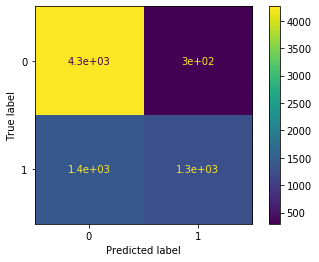

accuracy score:  0.7668422511782644
balanced accuracy score:  0.7067020186490709
roc auc score:  0.7067020186490709
<class 'pandas.core.series.Series'>
      Y  y_hat
0     0      0
1     1      0
2     1      0
3     0      0
4     0      0
...  ..    ...
7209  0      0
7210  0      0
7211  0      0
7212  0      0
7213  1      1

[7214 rows x 2 columns]


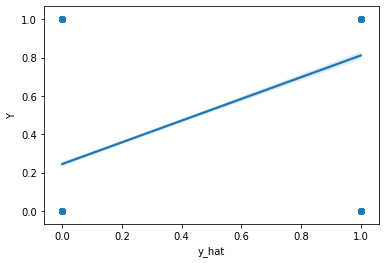

In [64]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# show a confusion matrix
print(confusion_matrix(Y, y_hat))

plot_confusion_matrix(classifier, X, Y)
plt.show() 

# compute accuracy, balanced accuracy, and roc_auc
print('accuracy score: ', accuracy_score(Y, y_hat))
print('balanced accuracy score: ', balanced_accuracy_score(Y, y_hat))
print('roc auc score: ', roc_auc_score(Y, y_hat))

# produce a regplot or calibration plot, plotting true rates on vertical axis against predictions on horizontal axis
import seaborn as sns
print(type(Y))
d = {'Y': Y.to_numpy(), 'y_hat': y_hat}

df = pd.DataFrame(data=d)
print(df)
ax = sns.regplot(x="y_hat", y="Y", data=df)

_(Optional)_ Interpret the model predictions _(this is week 12 material)_

In [14]:
# identify predictive features. 
# e.g. with logistic regression, show features with largest coefficients. with xgboost, show feature importance.
# TODO (optional)

# Analyze Judge Decisions

Do judges jail according to recidivism risk?

<class 'pandas.core.series.Series'>
      D  y_hat
0     1      0
1     1      0
2     1      0
3     0      0
4     0      0
...  ..    ...
7209  1      0
7210  1      0
7211  1      0
7212  1      0
7213  1      1

[7214 rows x 2 columns]


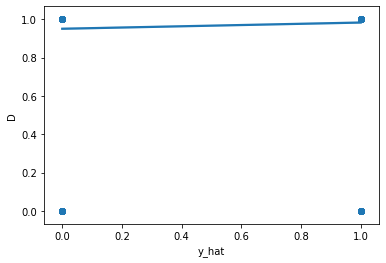

In [66]:
# produce a regplot with judge decision (D) on vertical axis and predicted recidivism probability (Yhat) on horizontal axis.
# TODO
import seaborn as sns
print(type(Y))
d = {'D': D.to_numpy(), 'y_hat': y_hat}

df = pd.DataFrame(data=d)
print(df)
ax = sns.regplot(x="y_hat", y="D", data=df)

# Build a Robot Judge

In [63]:
# average recidivism of released under human judges:
Y[D==0].mean()

0.08469055374592833

In [64]:
# average recidivism of jailed under human judges:
Y[D==1].mean()

0.3809179093673085

In [67]:
# predicted recidivism under human judges, for those released
#TODO: 
y_hat[D==0].mean() 

0.08794788273615635

In [68]:
# predicted recidivism under human judges, for those jailed
#TODO: 
y_hat[D==1].mean() 

0.22296221224844362

In [69]:
# N = number of defendants that judges jail.
N = D.sum()
N

6907

In [21]:
# sort dataset by increasing Y-hat (predicted recidivism)
#TODO


#not sure why we need to order the classifications. should we have choosen a continuous probability instead of binary classification?

# assign jail to the N riskiest defendants
Dstar = # TODO

In [70]:
# predicted recidivism under machine judges, for those released
y_hat[Dstar==0].mean() 

NameError: name 'Ypred' is not defined

In [ ]:
# predicted recidivism under machine judges, for those jailed
y_hat[Dstar==1].mean() 

_(Optional)_ Analyze differences between the robot and human judge (when D ≠ D*). What types of defendants do they disagree about?

In [32]:
# visualize differences in X when D != Dstar
# e.g., regress features that predict difference
# or train a model to predict divergence and show feature importance ranks. (optional)
# TODO

# (Optional) Predict Judge Decisions from Features

Use your preferred machine learning approach to predict the judge's jailing decision from defendant features. 

In [ ]:
# train a model in each training set to predict jail (D) from predictors (X)
# TODO

# form clean test-set predictions for decision in the full dataset
# TODO

Evaluate test set performance.

In [12]:
# show a confusion matrix
# TODO

# compute accuracy, balanced accuracy, and roc_auc
# TODO

# produce a calibration plot
# TODO

Interpret the model predictions.  _(optional, as this is week 12 material)_

In [19]:
# identify predictive features. (as above)
# TODO (optional)

# Compare to the predictive features from the previous section, and discuss any differences
# TODO (optional)